## EDA  🚡

In [1]:
# Importing libraries 
import os
import cv2
import ast
import json
import subprocess
from glob import glob
from tqdm.notebook import tqdm
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Video

In [2]:
df = pd.read_csv('../input/tensorflow-great-barrier-reef/train.csv')
df.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23501 entries, 0 to 23500
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        23501 non-null  int64 
 1   sequence        23501 non-null  int64 
 2   video_frame     23501 non-null  int64 
 3   sequence_frame  23501 non-null  int64 
 4   image_id        23501 non-null  object
 5   annotations     23501 non-null  object
dtypes: int64(4), object(2)
memory usage: 1.1+ MB


In [4]:
# Checking for duplicacy 
duplicate = df.duplicated().sum()
print('No. of duplicates :', duplicate)
print("_______________________________")
# Checking for no.of annotations per file
for video_id in df['video_id'].unique():
    print(f'video_id: {video_id}')
    print(f'with (w) annotations: {sum(df[df["video_id"]==video_id]["annotations"]=="[]")}')
    print(f'without (w/o) annotations: {sum(df[df["video_id"]==video_id]["annotations"]!="[]")}\n')

No. of duplicates : 0
_______________________________
video_id: 0
with (w) annotations: 4565
without (w/o) annotations: 2143

video_id: 1
with (w) annotations: 6133
without (w/o) annotations: 2099

video_id: 2
with (w) annotations: 7884
without (w/o) annotations: 677



In [5]:
# Bounding box

df[df.annotations.str.len()>2]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]"
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]"
18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]"
19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]"
20,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]"
...,...,...,...,...,...,...
23369,2,29859,10628,2856,2-10628,"[{'x': 92, 'y': 532, 'width': 40, 'height': 37}]"
23370,2,29859,10629,2857,2-10629,"[{'x': 78, 'y': 569, 'width': 40, 'height': 37}]"
23371,2,29859,10630,2858,2-10630,"[{'x': 65, 'y': 606, 'width': 41, 'height': 37}]"
23372,2,29859,10631,2859,2-10631,"[{'x': 51, 'y': 643, 'width': 44, 'height': 37}]"


## Visualizing the bbox on images ⭐⭐

In [6]:
## Visualizing the bbox on images 
# changing the type of annotations from str to list
df['annotations'] = df['annotations'].apply(ast.literal_eval)
# add path of images, number of boxes , differences
input_path = '../input/tensorflow-great-barrier-reef/train_images/'
df['image_path'] = input_path + 'video_' + df['video_id'].astype(str) + '/' + df['video_frame'].astype(str) +'.jpg'
df['num_bboxes'] = df['annotations'].apply(lambda x: len(x))
df['diff_num_bboxes'] = df['num_bboxes'].diff().fillna(0).astype(int)
df.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,image_path,num_bboxes,diff_num_bboxes
0,0,40258,0,0,0-0,[],../input/tensorflow-great-barrier-reef/train_i...,0,0
1,0,40258,1,1,0-1,[],../input/tensorflow-great-barrier-reef/train_i...,0,0
2,0,40258,2,2,0-2,[],../input/tensorflow-great-barrier-reef/train_i...,0,0
3,0,40258,3,3,0-3,[],../input/tensorflow-great-barrier-reef/train_i...,0,0
4,0,40258,4,4,0-4,[],../input/tensorflow-great-barrier-reef/train_i...,0,0


**Plotting the boxes on image**

In [7]:
"""Getting bounding box annotations"""
def get_bboxes(annotations):
    """
    annotations: list of annotations
    return: bboxes as [x_min, y_min, x_max, y_max]
    """
    if len(annotations) == 0:
        return []
    bboxes = pd.DataFrame(annotations, columns=['x', 'y', 'width', 'height']).astype(np.int32).values
    # [x_min, y_min , w, h] ->> [x_min, y_min , x_max, y_max]
    bboxes[:, 2] = bboxes[:, 0] + bboxes[:, 2]
    bboxes[:, 3] = bboxes[:, 1] + bboxes[:, 3]
    return bboxes

In [8]:
"""plotting the image"""
def plot_img_with_bbox(img_path, annotations):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig , ax = plt.subplots(1,1, figsize=(16,10))
    if len(annotations) > 0:
        bboxes = get_bboxes(annotations)
        for i, box in enumerate(bboxes):
            cv2.rectangle(img,(box[0], box[1]),(box[2], box[3]), color = (255, 0, 0), thickness= 2)
            # numbering
            ax.text(box[0], box[1]-5, i+1, color='red')
    ax.set_axis_off()
    ax.imshow(img)

In [9]:
sample_idx = 18
sample = df.iloc[sample_idx]
print(sample)

video_id                                                           0
sequence                                                       40258
video_frame                                                       18
sequence_frame                                                    18
image_id                                                        0-18
annotations        [{'x': 557, 'y': 213, 'width': 50, 'height': 32}]
image_path         ../input/tensorflow-great-barrier-reef/train_i...
num_bboxes                                                         1
diff_num_bboxes                                                    0
Name: 18, dtype: object


image_id: 0-18


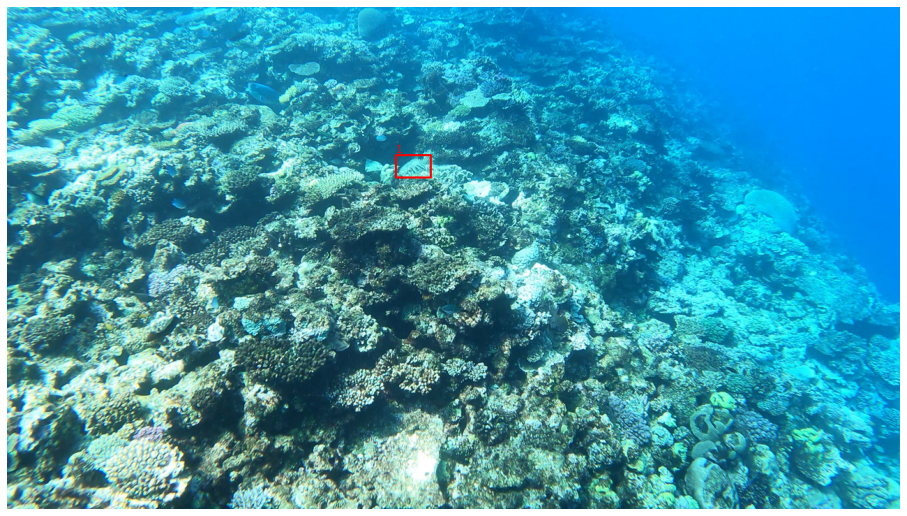

In [10]:
img_path    = sample['image_path']
annotations = sample['annotations']
print('image_id:', sample['image_id'])
# plot image with bboxes
plot_img_with_bbox(img_path, annotations)

Work in progress !!!!